<a href="https://colab.research.google.com/github/A125X/bitcoin-price-prediction/blob/main/art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
max_trials = 10
epochs = 100

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#!pip install keras-tuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
#!pip install yfinance
import yfinance as yf
from datetime import datetime
import pandas as pd
from numpy import concatenate

In [5]:
#Ensuring the use of gpu tensorflow

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Metal device set to: Apple M1

systemMemory: 8.00 GB
Default GPU Device:/device:GPU:0
maxCacheSize: 2.67 GB



2022-12-17 19:49:25.071704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 19:49:25.072087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-17 19:49:25.073755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 19:49:25.073772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
#Enter info regarding model

num_inputs=4
look_back = 60
forward_days = 1
num_periods = 20

[*********************100%***********************]  1 of 1 completed


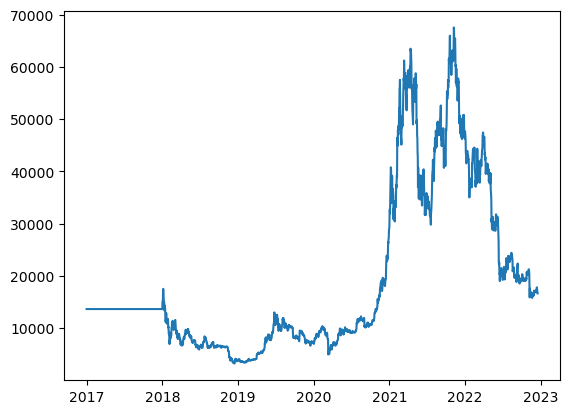

In [7]:
#data

today = datetime.today().strftime('%Y-%m-%d')
idx = pd.date_range('2017-01-01', today)

df_A = yf.download("BTC-USD", start="2018-01-01", end=today)
df_A = df_A["Close"]
df_A = df_A.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_A)

In [8]:
type(df_A)

pandas.core.series.Series

[*********************100%***********************]  1 of 1 completed


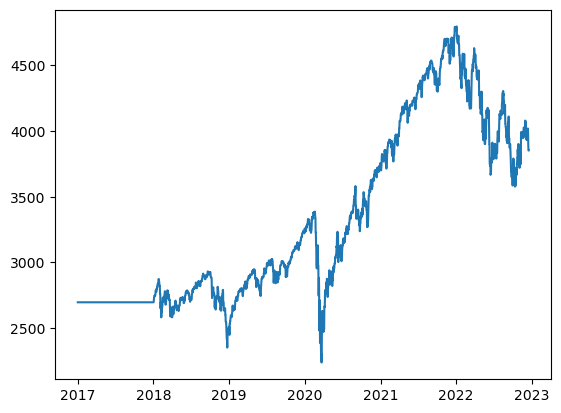

In [9]:
df_B = yf.download("%5EGSPC", start="2018-01-01", end=today)
df_B = df_B["Close"]
df_B = df_B.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_B)

[*********************100%***********************]  1 of 1 completed


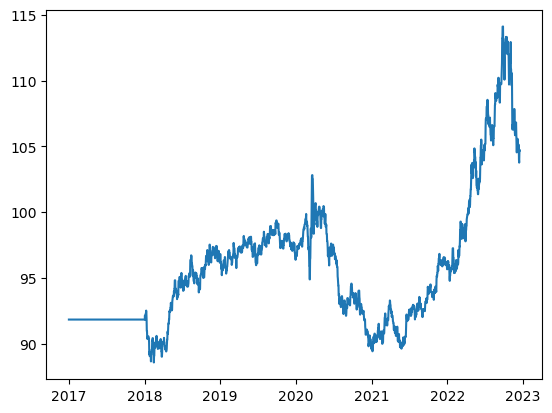

In [10]:
df_C = yf.download("DX-Y.NYB", start="2018-01-01", end=today)
df_C = df_C["Close"]
df_C = df_C.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_C)

[*********************100%***********************]  1 of 1 completed


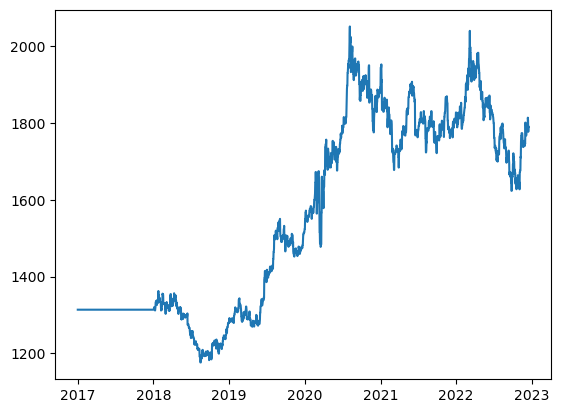

In [11]:
df_D = yf.download("GC=F", start="2018-01-01", end=today)
df_D = df_D["Close"]
df_D = df_D.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_D)

[*********************100%***********************]  1 of 1 completed


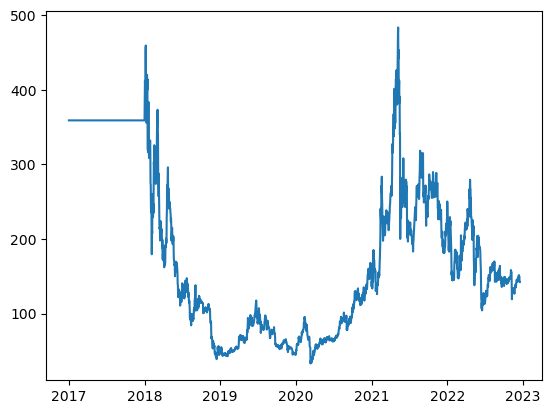

In [12]:
df_E = yf.download("XMR-USD", start="2018-01-01", end=today)["Close"]
df_E = df_E.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_E)

In [13]:
timeseries = pd.concat([df_A, df_B, df_C, df_D], axis=1)

timeseries.columns=(["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"])

In [14]:
scl = MinMaxScaler()

timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]] = scl.fit_transform(timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]])

timeseries["Close-btc-output"] = timeseries["Close-btc"].shift(-1)
timeseries.drop(timeseries.tail(1).index, inplace=True)

array = timeseries.values

timeseries.head()

,Close-btc,Close-sp500,Close-dxy,Close-gold,Close-btc-output
2017-01-01,0.161984,0.179125,0.127743,0.157089,0.161984
2017-01-02,0.161984,0.179125,0.127743,0.157089,0.161984
2017-01-03,0.161984,0.179125,0.127743,0.157089,0.161984
2017-01-04,0.161984,0.179125,0.127743,0.157089,0.161984
2017-01-05,0.161984,0.179125,0.127743,0.157089,0.161984


In [15]:
#split in Train and Test
division = len(array) - num_periods*forward_days

array_test = array[division:]
array_train = array[:division]
# split into input and outputs
X_train, Y_train = array_train[:, :-1], array_train[:, -1]
X_test, Y_test = array_test[:, :-1], array_test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [16]:
#Training the model

class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        
        # Specify model
        model = Sequential()
        NUM_NEURONS_FirstLayer = hp.Choice('NUM_NEURONS_FirstLayer',values=[80, 90, 100, 120])

        model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))

        model.add(Dropout(hp.Float('dropout_1', 0, 0.4, step=0.1, default=0)))

        
        NUM_NEURONS_SecondLayer = hp.Choice('NUM_NEURONS_SecondLayer',values=[30, 40, 50, 60, 70])
        model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))

        model.add(Dropout(hp.Float('dropout_2', 0, 0.4, step=0.1, default=0)))

        # Output layer
        model.add(Dense(forward_days, activation='linear'))

        # Compile the constructed model and return it
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[0.01, 0.001, 0.0001])),
            loss='mean_squared_error')

        return model

hypermodel = MyHyperModel(num_classes=1)    

In [17]:
# Construct the RandomSearch tuner
random_tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=max_trials,
    executions_per_trial = 1,
    seed=10, 
    project_name='lstm-kerastuner-multi',
    directory="models-temp")

# Search for the best parameters of the neural network using the contructed random search tuner
random_tuner.search(X_train, Y_train,
             epochs=epochs,
             validation_data=(X_validate, Y_validate))

Trial 10 Complete [00h 01m 11s]
val_loss: 0.0002051455230684951

Best val_loss So Far: 0.00019056345627177507
Total elapsed time: 01h 00m 44s
INFO:tensorflow:Oracle triggered exit


In [18]:
#get the best model

random_params = random_tuner.get_best_hyperparameters()[0]
best_model = random_tuner.get_best_models(1)[0]

In [19]:
#Evaluate it on the validation test

print("Evalutation of best performing model:")
print(best_model.evaluate(X_validate, Y_validate))

Evalutation of best performing model:


2022-12-17 20:50:15.159389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 20:50:15.233493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 20:50:15.297211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 11ms/step - loss: 1.9056e-04
0.00019056345627177507


In [20]:
#Get summary

random_tuner.results_summary()

Results summary
Results in models-temp/lstm-kerastuner-multi
Showing 10 best trials
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 120
dropout_1: 0.1
NUM_NEURONS_SecondLayer: 50
dropout_2: 0.2
learning_rate: 0.01
Score: 0.00019056345627177507
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 100
dropout_1: 0.1
NUM_NEURONS_SecondLayer: 70
dropout_2: 0.30000000000000004
learning_rate: 0.01
Score: 0.00019480742048472166
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 80
dropout_1: 0.2
NUM_NEURONS_SecondLayer: 60
dropout_2: 0.1
learning_rate: 0.01
Score: 0.00019669815083034337
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 100
dropout_1: 0.4
NUM_NEURONS_SecondLayer: 50
dropout_2: 0.2
learning_rate: 0.01
Score: 0.00019710976630449295
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 80
dropout_1: 0.4
NUM_NEURONS_SecondLayer: 30
dropout_2: 0.2
learning_rate: 0.01
Score: 0.0002051455230684951
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 120
dropout_1

In [21]:
#Saving the model

file_name = 'LSTM_BTC_tuned_multi.h5'
best_model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_BTC_tuned_multi.h5` to disk


1/1 [==============================] - 0s 374ms/step


2022-12-17 20:50:15.829893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 20:50:15.896224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 20:50:15.962222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


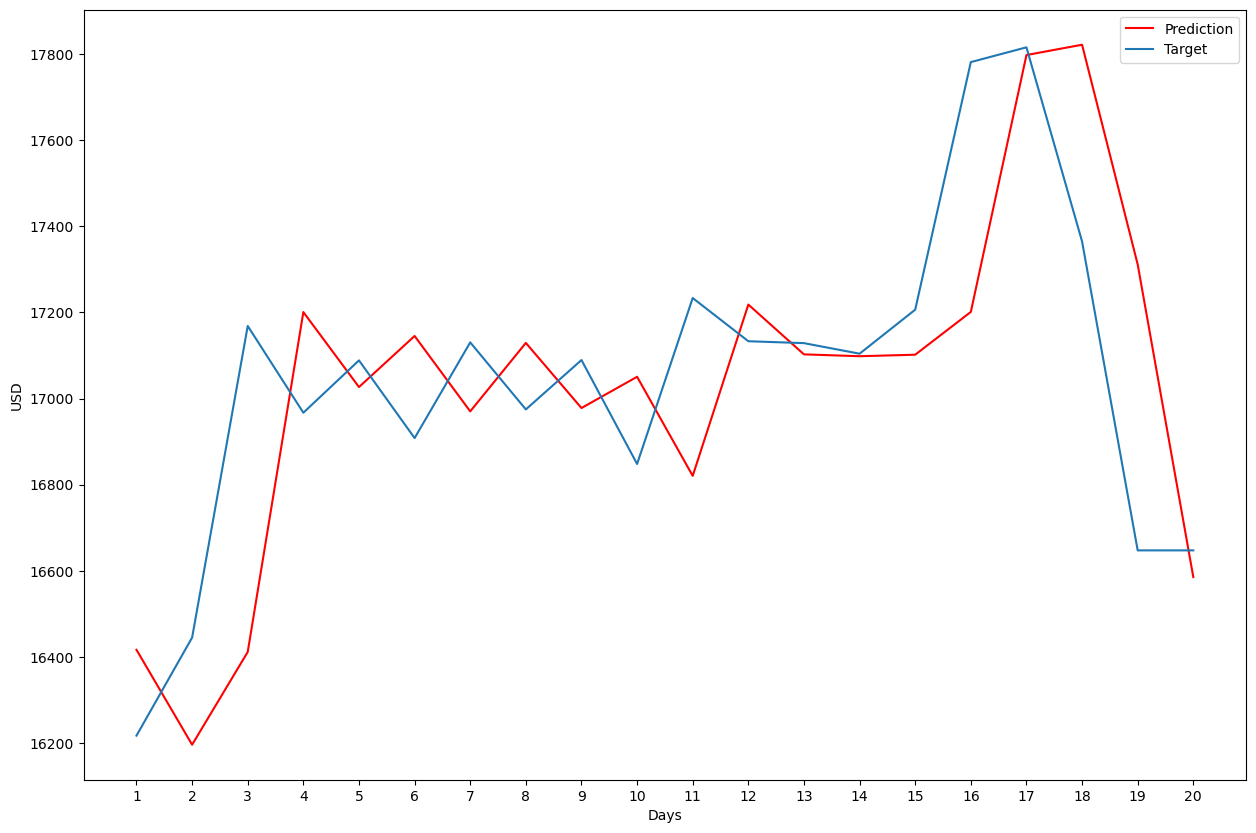

In [22]:
#Predict 

yhat = best_model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

inv_yhat = concatenate((yhat, X_test[:,1:]), axis=1)
inv_yhat = scl.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

Y_test = Y_test.reshape((len(Y_test)), 1)
inv_y = concatenate((Y_test, X_test[:, 1:]), axis=1)
inv_y = scl.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.figure(figsize = (15,10))
plt.plot(inv_yhat, color='r', label='Prediction') 
plt.plot(inv_y, label='Target')
plt.xticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()